<a href="https://colab.research.google.com/github/ZawWin58/firstproject/blob/master/dz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pylab as plt

import tensorflow as tf

In [8]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 112kB 7.3MB/s 
     |████████████████████████████████| 3.3MB 6.6MB/s 


In [9]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [10]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


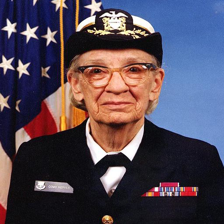

In [12]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [14]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


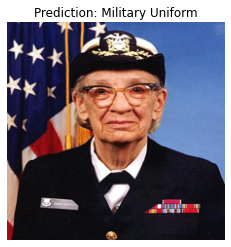

In [17]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [18]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 1s 0us/step


In [19]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [20]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [21]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['picket fence', 'maze', 'sea urchin', 'daisy', 'daisy',
       'coral fungus', 'bee', 'picket fence', 'lemon', 'spider web',
       "yellow lady's slipper", 'daisy', 'sea urchin', 'chime',
       'shower curtain', 'pot', 'pot', 'conch', 'castle', 'daisy', 'pot',
       'cabbage butterfly', 'rapeseed', 'slug', 'porcupine', 'torch',
       'banana', 'daisy', 'hip', 'daisy', 'picket fence', 'mushroom'],
      dtype='<U30')

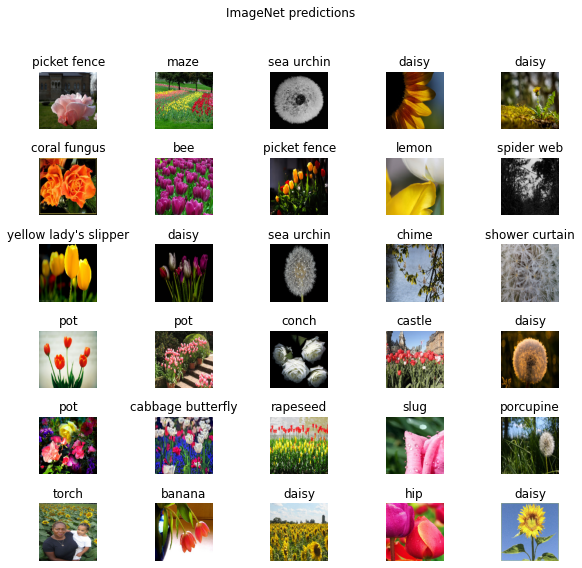

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [24]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [25]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [26]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [27]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [28]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [30]:
feature_extractor_layer.trainable = False

In [31]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
predictions = model(image_batch)

In [33]:
predictions.shape

TensorShape([32, 5])

In [34]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [35]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [36]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 118s 1s/step - loss: 0.5652 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 118s 1s/step - loss: 0.1913 - acc: 0.9375


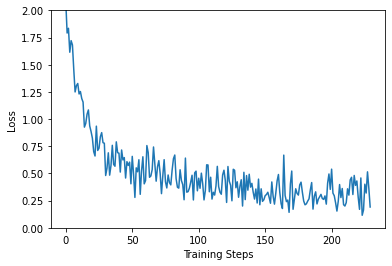

In [37]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

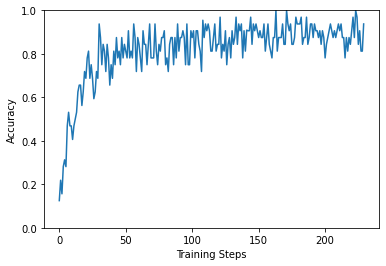

In [38]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [39]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [40]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [41]:
label_id = np.argmax(label_batch, axis=-1)

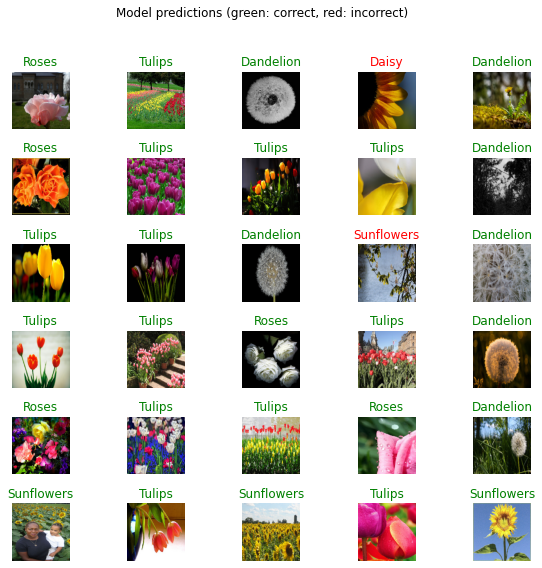

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [43]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1592438055/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1592438055/assets


'/tmp/saved_models/1592438055'

In [44]:
reloaded = tf.keras.models.load_model(export_path)

In [45]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [46]:
abs(reloaded_result_batch - result_batch).max()

0.0